In [ ]:
# %% Cell 1: Import Libraries and Setup
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print("TensorFlow version:", tf.__version__)



TensorFlow version: 2.18.0


In [ ]:
import kagglehub


!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# prompt: get data from kaggle on drive using

import kaggle



# Download the dataset
!kaggle datasets download -d anthonytherrien/image-classification-64-classes-animal -p /content/dataset

# Unzip the dataset
!unzip /content/dataset/image-classification-64-classes-animal.zip -d /content/dataset

# Now you can access the data in the /content/dataset directory


Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/image/koala/13103-701117758.png  
  inflating: /content/dataset/image/koala/13104-701117759.png  
  inflating: /content/dataset/image/koala/13105-701117760.png  
  inflating: /content/dataset/image/koala/13106-701117761.png  
  inflating: /content/dataset/image/koala/13107-701117762.png  
  inflating: /content/dataset/image/koala/13108-701117763.png  
  inflating: /content/dataset/image/koala/13109-701117764.png  
  inflating: /content/dataset/image/koala/13110-701117765.png  
  inflating: /content/dataset/image/koala/13111-701117766.png  
  inflating: /content/dataset/image/koala/13112-701117767.png  
  inflating: /content/dataset/image/koala/13113-701117768.png  
  inflating: /content/dataset/image/koala/13114-701117769.png  
  inflating: /content/dataset/image/koala/13115-701117770.png  
  inflating: /content/dataset/image/koala/13116-701117771.png  
  inflating: /content/dataset/image/koala/13117-70111

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array,img_to_array
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as mobilenet_preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import zipfile

In [ ]:
# %% Cell 2: Load Dataset from a single directory with subfolders for classes

data_dir = "/content/dataset/image"  # Adjust if your images folder is elsewhere
img_size = (224, 224)
batch_size = 32
seed = 123

# Training dataset (80%)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,      # 20% goes to validation
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"   # One-hot encoding for multi-class
)

# Validation dataset (20%)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"
)

class_names = train_ds.class_names
num_classes = len(class_names)

print(f"Detected {num_classes} classes:", class_names)


Found 14377 files belonging to 64 classes.
Using 11502 files for training.
Found 14377 files belonging to 64 classes.
Using 2875 files for validation.
Detected 64 classes: ['antelope', 'bear', 'beaver', 'bee', 'bison', 'blackbird', 'buffalo', 'butterfly', 'camel', 'cat', 'cheetah', 'chimpanzee', 'chinchilla', 'cow', 'crab', 'crocodile', 'deer', 'dog', 'dolphin', 'donkey', 'duck', 'eagle', 'elephant', 'falcon', 'ferret', 'flamingo', 'fox', 'frog', 'giraffe', 'goat', 'goose', 'gorilla', 'grasshopper', 'hawk', 'hedgehog', 'hippopotamus', 'hyena', 'iguana', 'jaguar', 'kangaroo', 'koala', 'lemur', 'leopard', 'lizard', 'lynx', 'mole', 'mongoose', 'ostrich', 'otter', 'owl', 'panda', 'peacock', 'penguin', 'porcupine', 'raccoon', 'seal', 'sheep', 'snail', 'snake', 'spider', 'squid', 'walrus', 'whale', 'wolf']


In [ ]:
# %% Cell 3: Data Augmentation & Prefetch
AUTOTUNE = tf.data.AUTOTUNE

# Basic augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Apply augmentation to training set only
def augment_images(image_batch, label_batch):
    return data_augmentation(image_batch), label_batch

train_ds = train_ds.map(augment_images, num_parallel_calls=AUTOTUNE)

# Prefetch to speed up training
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)


In [ ]:
# %% Cell 4: Build the Custom Model with ResNet101
base_model = ResNet101(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base ResNet101 layers

# Build classification head
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.applications.resnet.preprocess_input(inputs)
x = base_model(x, training=False)  # Forward pass in base model
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 224, 224)       │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 224, 224)       │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 224, 224)       │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 224, 224, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 224, 224, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet101 (Functional)    │ (None, 7, 7, 2048)     │     42,658,176 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ resnet101[0][0]        │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        524,544 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │         16,448 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 43,199,168 (164.79 MB)

 Trainable params: 540,992 (2.06 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

In [ ]:
# %% Cell 5: Train the Model
epochs = 10  # Adjust as needed

callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True),
    ModelCheckpoint("best_animal_model.h5", save_best_only=True, monitor="val_accuracy")
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)


Epoch 1/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.3292 - loss: 3.0415

360/360 ━━━━━━━━━━━━━━━━━━━━ 269s 677ms/step - accuracy: 0.3299 - loss: 3.0383 - val_accuracy: 0.9757 - val_loss: 0.2205
Epoch 2/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.9103 - loss: 0.4193

360/360 ━━━━━━━━━━━━━━━━━━━━ 208s 576ms/step - accuracy: 0.9103 - loss: 0.4190 - val_accuracy: 0.9899 - val_loss: 0.0690
Epoch 3/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.9583 - loss: 0.1846

360/360 ━━━━━━━━━━━━━━━━━━━━ 223s 618ms/step - accuracy: 0.9584 - loss: 0.1845 - val_accuracy: 0.9920 - val_loss: 0.0408
Epoch 4/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.9723 - loss: 0.1220

360/360 ━━━━━━━━━━━━━━━━━━━━ 278s 662ms/step - accuracy: 0.9723 - loss: 0.1219 - val_accuracy: 0.9962 - val_loss: 0.0256
Epoch 5/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 265s 671ms/step - accuracy: 0.9786 - loss: 0.0909 - val_accuracy: 0.9958 - val_loss: 0.0214
Epoch 6/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.9855 - loss: 0.0629

360/360 ━━━━━━━━━━━━━━━━━━━━ 243s 618ms/step - accuracy: 0.9855 - loss: 0.0629 - val_accuracy: 0.9986 - val_loss: 0.0145
Epoch 7/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 204s 564ms/step - accuracy: 0.9898 - loss: 0.0488 - val_accuracy: 0.9976 - val_loss: 0.0131
Epoch 8/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.9913 - loss: 0.0438

360/360 ━━━━━━━━━━━━━━━━━━━━ 222s 617ms/step - accuracy: 0.9913 - loss: 0.0438 - val_accuracy: 0.9990 - val_loss: 0.0101
Epoch 9/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 280s 667ms/step - accuracy: 0.9893 - loss: 0.0420 - val_accuracy: 0.9979 - val_loss: 0.0096
Epoch 10/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 262s 668ms/step - accuracy: 0.9909 - loss: 0.0343 - val_accuracy: 0.9983 - val_loss: 0.0085


In [ ]:
# prompt: save model using pickle

import pickle

# Assuming your trained model is called 'model'
# Save the model to a file using pickle
with open('animal_classification_model.pkl', 'wb') as f:
    pickle.dump(model, f)


In [ ]:
# prompt: load model

import pickle

# Load the model from the pickle file
with open('animal_classification_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Now you can use 'loaded_model' to make predictions


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# prompt: save model using all types

# ... (Your existing code) ...

# %% Cell 6: Save the Model in different formats

# Save the model as a SavedModel (recommended for TensorFlow)
#model.save("animal_classification_model_savedmodel")

# Save the model architecture and weights in HDF5 format
model.save("animal_classification_model.h5")

# Save weights only
model.save_weights("animal_classification_model_weights.h5")


# ... (Rest of your code) ...


ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=animal_classification_model_savedmodel.

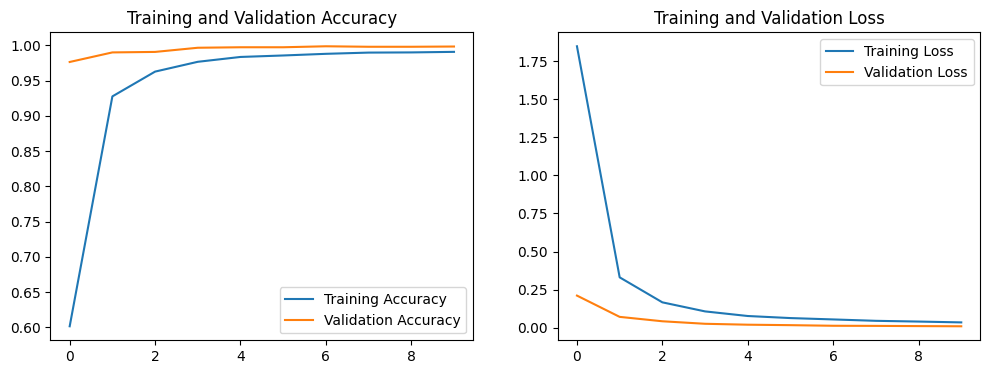

In [ ]:
# prompt: test model

# %% Cell 6: Plot Training History

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
# prompt: save model

# Assuming the model is already trained and 'history' object exists

# Save the entire model
model.save("my_model.h5")


# Or save only the weights
#model.save_weights("my_model_weights")
model.save("my_model.keras")  # Use .keras format instead of .h5


#To load the model later
# Load the entire model
# loaded_model = tf.keras.models.load_model("my_model")

# Load only the weights
# new_model = create_the_same_model_architecture() # Create a model with the same architecture as the saved model
# new_model.load_weights('my_model_weights.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Predicted class: bison


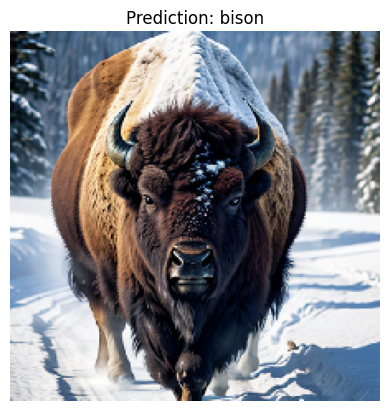

In [ ]:
# prompt: test model on random image

import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the saved model
model = tf.keras.models.load_model("my_model.keras")


# Define a function to preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet.preprocess_input(img_array)
    return img_array

# Example usage
image_path = "/content/dataset/image/bison/08641-2050076453.png"  # Replace with the actual path to your image

try:
    preprocessed_image = preprocess_image(image_path)
    predictions = model.predict(preprocessed_image)

    # Get the predicted class index
    predicted_class_index = np.argmax(predictions[0])

    # Assuming class_names is available (e.g., from training)
    class_names = ['antelope', 'bear', 'beaver', 'bee', 'bison', 'blackbird', 'buffalo', 'butterfly', 'camel', 'cat', 'cheetah', 'chimpanzee', 'chinchilla', 'cow', 'crab', 'crocodile', 'deer', 'dog', 'dolphin', 'donkey', 'duck', 'eagle', 'elephant', 'falcon', 'ferret', 'flamingo', 'fox', 'frog', 'giraffe', 'goat', 'goose', 'gorilla', 'grasshopper', 'hawk', 'hedgehog', 'hippopotamus', 'hyena', 'iguana', 'jaguar', 'kangaroo', 'koala', 'lemur', 'leopard', 'lizard', 'lynx', 'mole', 'mongoose', 'ostrich', 'otter', 'owl', 'panda', 'peacock', 'penguin', 'porcupine', 'raccoon', 'seal', 'sheep', 'snail', 'snake', 'spider', 'squid', 'walrus', 'whale', 'wolf'] # Replace with your actual class names

    predicted_class = class_names[predicted_class_index]
    print("Predicted class:", predicted_class)

    # Display the image and prediction
    img = image.load_img(image_path, target_size=(224, 224))
    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class}")
    plt.axis('off')
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")


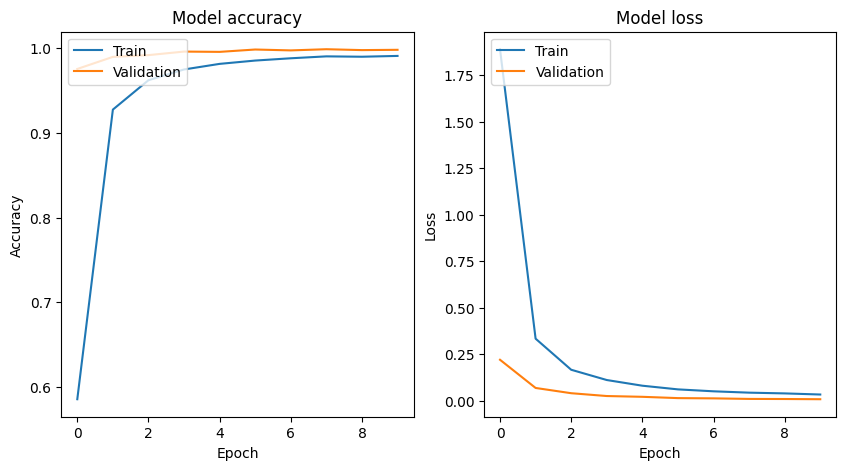

In [ ]:
# prompt: draw graph

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


90/90 ━━━━━━━━━━━━━━━━━━━━ 39s 345ms/step


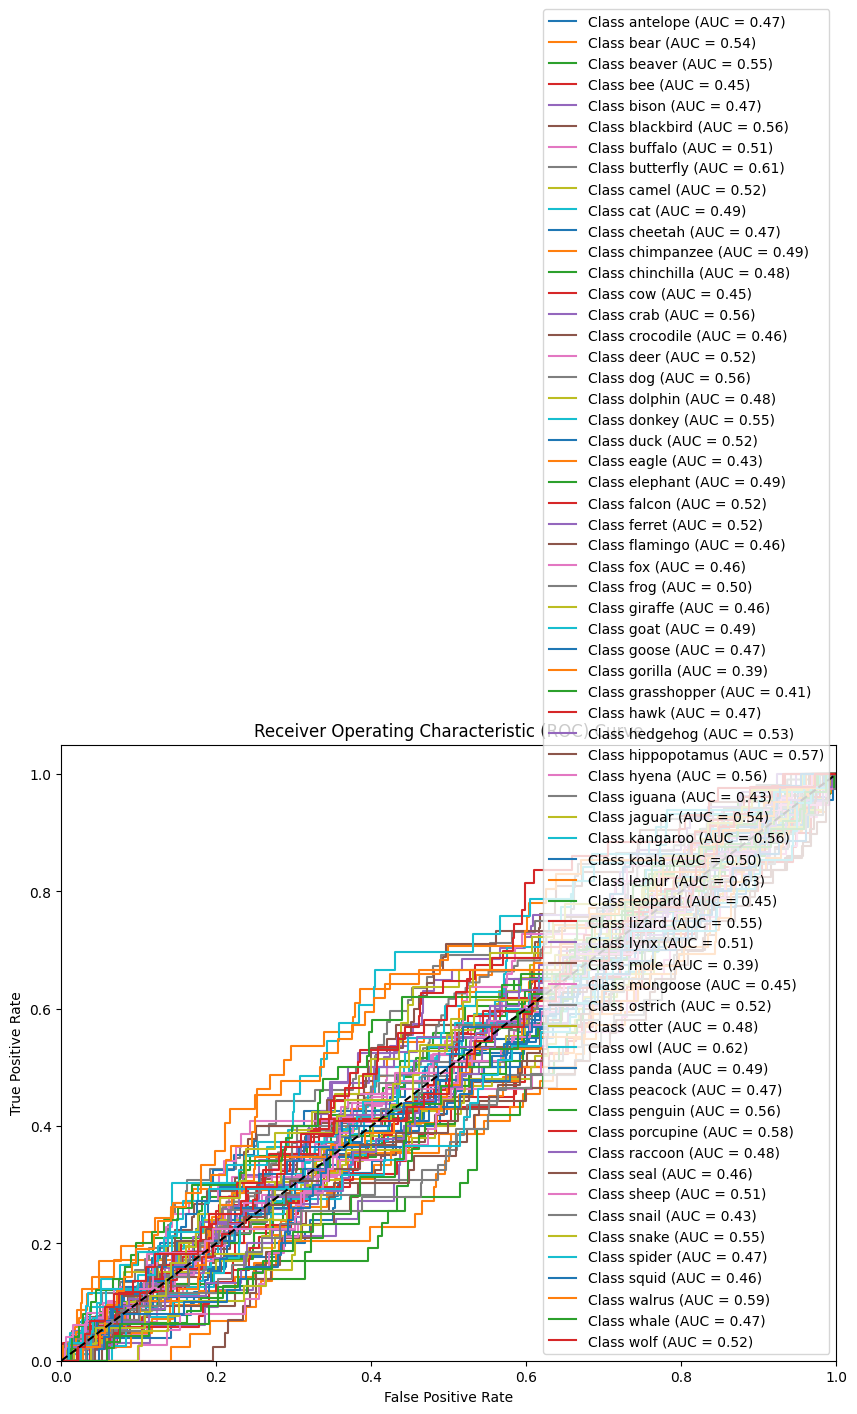

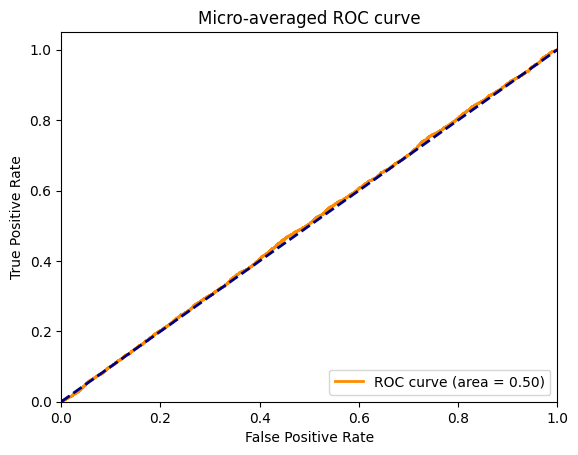

In [ ]:
# prompt: all roc auc and graphs

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming 'model' and 'val_ds' are defined from previous code

# Get predictions for the validation set
y_pred = model.predict(val_ds)

# Convert validation labels to one-hot encoding if they aren't already
# (This step might not be needed depending on how val_ds is created)
import numpy as np
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Calculate ROC AUC for each class
n_classes = y_true.shape[1]  # Number of classes

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(n_classes):
  plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color="darkorange", lw=lw, label="ROC curve (area = %0.2f)" % roc_auc["micro"])
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged ROC curve")
plt.legend(loc="lower right")
plt.show()


In [ ]:
import tkinter as tk
from tkinter import filedialog, messagebox
import numpy as np
import cv2
import tensorflow as tf
from PIL import Image, ImageTk

############################
# 1. Load Your Classification Model
############################
MODEL_PATH = "my_model.keras"  # Adjust if needed
model = tf.keras.models.load_model(MODEL_PATH)
model_input_size = (224, 224)  # Model input size

# Classes in the same order as the model’s output layer
class_names = [
    "antelope", "bear", "beaver", "bee", "bison", "blackbird",
    "buffalo", "butterfly", "camel", "cat", "cheetah", "chimpanzee",
    "chinchilla", "cow", "crab", "crocodile", "deer", "dog", "dolphin",
    # ... Fill in your full list
]

# Define carnivores
carnivores = {"bear", "cat", "cheetah", "crocodile", "dog", "lion", "tiger"}  # etc.

############################
# 2. Sliding Window Function
############################
def sliding_window(image, step, window_size):
    """
    Yields (x, y, patch) for each sub-window in 'image' of size 'window_size',
    moving in increments of 'step' pixels horizontally and vertically.
    """
    h, w = image.shape[:2]
    winH, winW = window_size
    for y in range(0, h - winH + 1, step):
        for x in range(0, w - winW + 1, step):
            patch = image[y:y+winH, x:x+winW]
            yield (x, y, patch)

############################
# 3. Naive Detection with Classification Model
############################
def detect_objects_sliding_window(
    image_bgr,
    model,
    step=64,
    window_size=(224, 224),
    threshold=0.8
):
    """
    Scans the image using a sliding window. For each patch:
      - Resize to model's input size (224x224).
      - Predict class probabilities.
      - If max probability >= threshold, record detection.
    Returns a list of detection dicts with "box", "score", "class_name".
    """
    detections = []
    h, w = image_bgr.shape[:2]
    winH, winW = window_size

    if h < winH or w < winW:
        print("Image is smaller than the window size!")
        return detections

    for (x, y, patch) in sliding_window(image_bgr, step, window_size):
        # Resize patch for model input
        patch_resized = cv2.resize(patch, model_input_size)
        # Expand dims and cast
        patch_array = np.expand_dims(patch_resized, axis=0).astype(np.float32)

        # Optional: Preprocess if your model used specific preprocessing
        # from tensorflow.keras.applications.resnet import preprocess_input
        # patch_array = preprocess_input(patch_array)

        # Predict
        preds = model.predict(patch_array, verbose=0)
        conf = np.max(preds[0])
        class_idx = np.argmax(preds[0])

        if conf >= threshold:
            class_name = class_names[class_idx]
            detections.append({
                "box": (x, y, winW, winH),
                "score": float(conf),
                "class_name": class_name
            })
    return detections

############################
# 4. Draw Detections
############################
def draw_detections(image_bgr, detections):
    """
    Draw bounding boxes on image for each detection.
    Red for carnivores, green for others.
    """
    for det in detections:
        x, y, w, h = det["box"]
        score = det["score"]
        cls_name = det["class_name"]

        color = (0, 0, 255) if cls_name in carnivores else (0, 255, 0)
        cv2.rectangle(image_bgr, (x, y), (x + w, y + h), color, 2)
        label = f"{cls_name} {score:.2f}"
        cv2.putText(
            image_bgr, label,
            (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2
        )
    return image_bgr

############################
# 5. Tkinter GUI
############################
root = tk.Tk()
root.title("Naive Object Detection with Classification Model")
root.geometry("800x600")

lbl_info = tk.Label(root, text="Upload an Image to Detect Animals", font=("Arial", 14))
lbl_info.pack(pady=10)

lbl_image = tk.Label(root)
lbl_image.pack()

def upload_and_detect():
    file_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.jpg *.png *.jpeg")])
    if not file_path:
        return

    # Read image (BGR)
    image_bgr = cv2.imread(file_path)
    if image_bgr is None:
        messagebox.showerror("Error", "Failed to open image.")
        return

    # Run naive sliding-window detection
    step_size = 64
    window_sz = (224, 224)
    threshold = 0.8
    detections = detect_objects_sliding_window(
        image_bgr, model, step=step_size, window_size=window_sz, threshold=threshold
    )

    # Draw boxes
    image_bgr_with_boxes = draw_detections(image_bgr.copy(), detections)

    # Count carnivores
    carn_count = sum(det["class_name"] in carnivores for det in detections)
    if carn_count > 0:
        messagebox.showinfo("Carnivore Alert", f"Detected {carn_count} carnivorous animal(s)!")

    # Convert to RGB for display
    image_rgb = cv2.cvtColor(image_bgr_with_boxes, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(image_rgb)
    pil_img.thumbnail((600, 400))  # Resize for display in GUI
    tk_img = ImageTk.PhotoImage(pil_img)

    lbl_image.config(image=tk_img)
    lbl_image.image = tk_img

btn_upload = tk.Button(root, text="Upload Image", font=("Arial", 12), command=upload_and_detect)
btn_upload.pack(pady=10)

root.mainloop()


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


TclError: no display name and no $DISPLAY environment variable